<a href="https://colab.research.google.com/github/sthanikan2000/CS3121-Project/blob/main/DS_Proj_employee_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, train_test_split

from scipy.stats import pointbiserialr
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Read the CSV file into a DataFrame
emp = pd.read_csv('employees.csv')

In [3]:
emp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997 entries, 0 to 996
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Employee_No          997 non-null    int64 
 1   Employee_Code        997 non-null    int64 
 2   Name                 997 non-null    object
 3   Title                997 non-null    object
 4   Gender               997 non-null    object
 5   Religion_ID          997 non-null    int64 
 6   Marital_Status       930 non-null    object
 7   Designation_ID       997 non-null    int64 
 8   Date_Joined          997 non-null    object
 9   Date_Resigned        997 non-null    object
 10  Status               997 non-null    object
 11  Inactive_Date        997 non-null    object
 12  Reporting_emp_1      997 non-null    object
 13  Reporting_emp_2      997 non-null    object
 14  Employment_Category  997 non-null    object
 15  Employment_Type      997 non-null    object
 16  Religion

## ***Pre-processing tasks carried out before imputing missing values***

In [4]:
# Replace "0000" with NaN in 'Year_of_Birth'
emp['Year_of_Birth'] = emp['Year_of_Birth'].replace("'0000'", '0000')
emp['Year_of_Birth'] = emp['Year_of_Birth'].astype('int64')
emp['Year_of_Birth'] = emp['Year_of_Birth'].replace(0, np.nan)

In [5]:
(emp["Status"]=="Inactive").sum()

764

In [6]:
((emp['Status'] == 'Inactive') & (emp['Date_Resigned'].isin(['\\N', '0000-00-00']))).sum()

223

223 null records when status is Inactive

In [7]:
((emp['Status'] == 'Inactive')&(emp['Inactive_Date'].isin(['\\N', '0000-00-00']))).sum()

0

So, there is no null records for Inactive_Date when status is Inactive

In [8]:
(((~emp['Inactive_Date'].isin(['\\N', '0000-00-00']))&( emp['Inactive_Date']!=emp['Date_Resigned']))&(~emp['Date_Resigned'].isin(['\\N', '0000-00-00']))).sum()

6

Which means only 6 records are having different dates for Inactive_Date and Date_Resigned.

**So we can impute the Date_Resigned = Inactive_Date as follows:**

In [9]:
# Impute Date_resigned
mask = (emp['Status'] == 'Inactive') & (emp['Date_Resigned'].isin(['\\N', '0000-00-00'])) & (~emp['Inactive_Date'].isin(['\\N', '0000-00-00']))
emp.loc[mask, 'Date_Resigned'] = emp.loc[mask, 'Inactive_Date']

# Replace '\\N' and '0000-00-00' with NaN
emp['Date_Resigned'].replace(['\\N', '0000-00-00'], np.nan, inplace=True)
emp['Inactive_Date'].replace(['\\N', '0000-00-00'], np.nan, inplace=True)
emp['Reporting_emp_1'].replace(['\\N'], np.nan, inplace=True)
emp['Reporting_emp_2'].replace(['\\N'], np.nan, inplace=True)


In [10]:
mask = (emp["Gender"]=="Female")&(emp["Title"]=="Mr")

# Since "Ms" is a title used for addressing a woman without specifying her marital status. It can be used for both married and unmarried women.
emp.loc[mask, "Title"] = "Ms"

In [11]:
mask = (emp["Gender"]=="Male")&(emp["Title"].isin(["Ms","Miss"]))

# Since "Mr" is a title used for addressing a man without specifying his marital status. It can be used for both married and unmarried men.
emp.loc[mask, "Title"] = "Mr"

In [12]:
mask = (emp["Title"].isin(["Miss"]))&(emp["Marital_Status"]=="Married")
emp.loc[mask, "Marital_Status"] = "Single"

In [13]:
# Parse columns to datetime format to get all  date times in same format
for i in ["Date_Joined","Date_Resigned","Inactive_Date"]:
  emp[i] = pd.to_datetime(emp[i])

In [14]:
emp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997 entries, 0 to 996
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Employee_No          997 non-null    int64         
 1   Employee_Code        997 non-null    int64         
 2   Name                 997 non-null    object        
 3   Title                997 non-null    object        
 4   Gender               997 non-null    object        
 5   Religion_ID          997 non-null    int64         
 6   Marital_Status       930 non-null    object        
 7   Designation_ID       997 non-null    int64         
 8   Date_Joined          997 non-null    datetime64[ns]
 9   Date_Resigned        764 non-null    datetime64[ns]
 10  Status               997 non-null    object        
 11  Inactive_Date        764 non-null    datetime64[ns]
 12  Reporting_emp_1      61 non-null     object        
 13  Reporting_emp_2      0 non-null    

"Reporting_emp_1" and "Reporting_emp_2" are with too much of null values.

In [15]:
emp.nunique()

Employee_No            997
Employee_Code          997
Name                   997
Title                    3
Gender                   2
Religion_ID              4
Marital_Status           2
Designation_ID         129
Date_Joined            549
Date_Resigned          350
Status                   2
Inactive_Date          350
Reporting_emp_1         23
Reporting_emp_2          0
Employment_Category      3
Employment_Type          2
Religion                 4
Designation            129
Year_of_Birth           59
dtype: int64

In [16]:
correlation, p_value = spearmanr(emp['Employee_No'], emp['Employee_Code'])
print(correlation,p_value)

0.7602284241235672 1.3854939188613603e-188


In [17]:
df_sorted = emp.sort_values('Employee_No', ascending=True)
df_sorted['Employee_Code'].is_monotonic_increasing

False

**Why the above are not return p-value as exactly 0?**

Because Employee_Code doesn't have any monotonic relationship with Employee_No. So, Employee_Code is not ordinal.

In [18]:
observed = pd.crosstab(emp['Religion'], emp['Religion_ID'])
# print(observed) # Prints the contigency table
# Perform chi-square test
chi2, p_value, _, _ = chi2_contingency(observed)
print("\nChi-square test between Religion and Religion_ID")
print("Chi-square statistic:", chi2)
print("P-value:", p_value)

observed = pd.crosstab(emp['Designation'], emp['Designation_ID'])
# print(observed) # Prints the contigency table
# Perform chi-square test
chi2, p_value, _, _ = chi2_contingency(observed)
print("\nChi-square test between Designation and Designation_ID")
print("Chi-square statistic:", chi2)
print("P-value:", p_value)


Chi-square test between Religion and Religion_ID
Chi-square statistic: 2991.0
P-value: 0.0

Chi-square test between Designation and Designation_ID
Chi-square statistic: 127616.00000000001
P-value: 0.0


In the above result p-value is exactly 0 for both which means they are correlated with each other. So, having one out of two variable in our dataset is sufficient.

In [19]:
# we are not using "Employee_Code", "Name", and Inactive_Date for futher analysis.
emp.drop(["Employee_Code","Name","Reporting_emp_1","Reporting_emp_2","Religion_ID","Designation_ID","Inactive_Date"], axis=1, inplace=True)

In [20]:
df1=pd.read_csv("attendance_preprocessed_200635E.csv")
df2=pd.read_csv("leaves_preprocessed_200635E.csv")
df3=pd.read_csv("salary_preprocessed_200635E.csv")

In [21]:
merged_df = pd.merge(emp, df1, on='Employee_No', how='left')
print(merged_df.shape)
merged_df = pd.merge(merged_df, df2, on='Employee_No', how='left')
print(merged_df.shape)
merged_df = pd.merge(merged_df, df3, on='Employee_No', how='left')
merged_df.info()

(997, 14)
(997, 18)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 997 entries, 0 to 996
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Employee_No          997 non-null    int64         
 1   Title                997 non-null    object        
 2   Gender               997 non-null    object        
 3   Marital_Status       930 non-null    object        
 4   Date_Joined          997 non-null    datetime64[ns]
 5   Date_Resigned        764 non-null    datetime64[ns]
 6   Status               997 non-null    object        
 7   Employment_Category  997 non-null    object        
 8   Employment_Type      997 non-null    object        
 9   Religion             997 non-null    object        
 10  Designation          997 non-null    object        
 11  Year_of_Birth        894 non-null    float64       
 12  Hourly_Time          742 non-null    float64       
 13  Late_minutes   

In [22]:
merged_df['Year_Joined'] = merged_df['Date_Joined'].dt.year

## ***Finding the variables having high association with the Marital_Status***

In [23]:
non_null_marital_status=merged_df[~(merged_df["Marital_Status"].isnull())].copy()
non_null_marital_status.shape

(930, 21)

In [24]:
non_null_marital_status.columns

Index(['Employee_No', 'Title', 'Gender', 'Marital_Status', 'Date_Joined',
       'Date_Resigned', 'Status', 'Employment_Category', 'Employment_Type',
       'Religion', 'Designation', 'Year_of_Birth', 'Hourly_Time',
       'Late_minutes', 'Type_Full Day', 'Type_Half Day', 'apply_type_Anual',
       'apply_type_Casual', 'Earnings', 'Total Fixed', 'Year_Joined'],
      dtype='object')

In [25]:
for var in ['Title', 'Gender','Status', 'Employment_Category', 'Employment_Type','Religion', 'Designation']:
  contingency_table = pd.crosstab(non_null_marital_status[var], non_null_marital_status['Marital_Status'])
  chi2, p_value, dof, expected = chi2_contingency(contingency_table)
  print("\nChi-square test between %s and Marital_Status"%(var))
  print("Chi-square test statistic:", chi2)
  print("p-value:", p_value)
  # print("Degrees of freedom:", dof)
  # print("Expected frequencies table:")
  # print(expected)



Chi-square test between Title and Marital_Status
Chi-square test statistic: 29.943033220501565
p-value: 3.14740731935932e-07

Chi-square test between Gender and Marital_Status
Chi-square test statistic: 24.624015122960706
p-value: 6.967796901622455e-07

Chi-square test between Status and Marital_Status
Chi-square test statistic: 2.6547135877875405
p-value: 0.10324335137681154

Chi-square test between Employment_Category and Marital_Status
Chi-square test statistic: 44.40298087091607
p-value: 2.280421956497292e-10

Chi-square test between Employment_Type and Marital_Status
Chi-square test statistic: 4.238995183058099
p-value: 0.03950554164963643

Chi-square test between Religion and Marital_Status
Chi-square test statistic: 15.364680489631626
p-value: 0.0015300937613123434

Chi-square test between Designation and Marital_Status
Chi-square test statistic: 253.78700731117002
p-value: 2.815823412279475e-11


In [26]:
non_null_marital_status['Marital_Status_Encoded'] = non_null_marital_status['Marital_Status'].map({'Single': 0, 'Married': 1})
for var in ["Year_Joined"]:
  correlation, p_value = pointbiserialr(non_null_marital_status[var], non_null_marital_status['Marital_Status_Encoded'])
  print("\nPoint-biserial correlation coefficient between %s and Marital_Status"%(var))
  print("correlation coefficient:", correlation)
  print("p-value:", p_value)

temp=non_null_marital_status[~non_null_marital_status["Year_of_Birth"].isnull()].copy()
var="Year_of_Birth"
correlation, p_value = pointbiserialr(temp[var], temp['Marital_Status_Encoded'])
print("\nPoint-biserial correlation coefficient between %s and Marital_Status"%(var))
print("correlation coefficient:", correlation)
print("p-value:", p_value)


Point-biserial correlation coefficient between Year_Joined and Marital_Status
correlation coefficient: -0.059639131224388964
p-value: 0.06907615799811134

Point-biserial correlation coefficient between Year_of_Birth and Marital_Status
correlation coefficient: -0.6093927990422292
p-value: 3.883410430036145e-86


In [27]:
mask1=merged_df["Hourly_Time"].isnull() | merged_df["Marital_Status"].isnull()
mask2=merged_df["Type_Full Day"].isnull() | merged_df["Marital_Status"].isnull()
mask3=merged_df["Earnings"].isnull()| merged_df["Marital_Status"].isnull()

In [28]:
non_null_hourly=merged_df[~mask1].copy()
non_null_hourly['Marital_Status'] = non_null_hourly['Marital_Status'].map({'Single': 0, 'Married': 1})

correlation, p_value = pointbiserialr(non_null_hourly['Hourly_Time'], non_null_hourly['Marital_Status'])
print("Point-biserial correlation coefficient between Hourly_Time and Marital_Status")
print("correlation coefficient:", correlation)
print("p-value:", p_value)

correlation, p_value = pointbiserialr(non_null_hourly['Late_minutes'], non_null_hourly['Marital_Status'])
print("Point-biserial correlation coefficient between Late_minutes and Marital_Status")
print("correlation coefficient:", correlation)
print("p-value:", p_value)

Point-biserial correlation coefficient between Hourly_Time and Marital_Status
correlation coefficient: 0.027776670254683743
p-value: 0.4689426939478626
Point-biserial correlation coefficient between Late_minutes and Marital_Status
correlation coefficient: -0.07599441659352534
p-value: 0.04727446782030857


In [29]:
non_null_types=merged_df[~mask2].copy()
non_null_types['Status'] = non_null_types['Marital_Status'].map({'Single': 0, 'Married': 1})

correlation, p_value = pointbiserialr(non_null_types['Type_Full Day'], non_null_types['Status'])
print("Point-biserial correlation coefficient between Type_Full Day and Marital_Status")
print("correlation coefficient:", correlation)
print("p-value:", p_value)

correlation, p_value = pointbiserialr(non_null_types['Type_Half Day'], non_null_types['Status'])
print("Point-biserial correlation coefficient between Type_Half Day and Marital_Status")
print("correlation coefficient:", correlation)
print("p-value:", p_value)

correlation, p_value = pointbiserialr(non_null_types['apply_type_Anual'], non_null_types['Status'])
print("Point-biserial correlation coefficient between apply_type_Anual and Marital_Status")
print("correlation coefficient:", correlation)
print("p-value:", p_value)

correlation, p_value = pointbiserialr(non_null_types['apply_type_Casual'], non_null_types['Status'])
print("Point-biserial correlation coefficient between apply_type_Casual and MArital_Status")
print("correlation coefficient:", correlation)
print("p-value:", p_value)

Point-biserial correlation coefficient between Type_Full Day and Marital_Status
correlation coefficient: -0.018854941530374605
p-value: 0.8944532087318575
Point-biserial correlation coefficient between Type_Half Day and Marital_Status
correlation coefficient: -0.1286231810396556
p-value: 0.36348178984104806
Point-biserial correlation coefficient between apply_type_Anual and Marital_Status
correlation coefficient: -0.03722466811116393
p-value: 0.793324230168613
Point-biserial correlation coefficient between apply_type_Casual and MArital_Status
correlation coefficient: -0.08277149204042508
p-value: 0.5596464130974419


In [30]:
non_null_earnings=merged_df[~mask3].copy()
non_null_earnings['Status'] = non_null_earnings['Marital_Status'].map({'Single': 0, 'Married': 1})

correlation, p_value = pointbiserialr(non_null_earnings['Earnings'], non_null_earnings['Status'])
print("Point-biserial correlation coefficient between Earnings and Marital_Status")
print("correlation coefficient:", correlation)
print("p-value:", p_value)

correlation, p_value = pointbiserialr(non_null_earnings['Total Fixed'], non_null_earnings['Status'])
print("Point-biserial correlation coefficient between Total Fixed and Marital_Status")
print("correlation coefficient:", correlation)
print("p-value:", p_value)

Point-biserial correlation coefficient between Earnings and Marital_Status
correlation coefficient: 0.016983619820182885
p-value: 0.6619849724319578
Point-biserial correlation coefficient between Total Fixed and Marital_Status
correlation coefficient: -0.04841084948636193
p-value: 0.21247752853240628


## ***Finding the variables having high association with the Year_of_Birth***

In [31]:
((~merged_df["Marital_Status"].isnull()) & (~merged_df["Year_of_Birth"].isnull())).sum()

836

In [32]:
non_null_yob=merged_df[~(merged_df["Year_of_Birth"].isnull())].copy()
non_null_yob.shape

(894, 21)

In [33]:
# df = emp[["Employee_No", 'Religion', "Title", "Gender", "Status", "Employment_Category", "Employment_Type", "Designation", "Marital_Status", "Year_of_Birth"]].copy()
# df['Year_Joined'] = emp['Date_Joined'].dt.year

# Label encoding the categorical nominal variables
le = LabelEncoder()

for var in ['Title', 'Gender', 'Status', 'Employment_Category', 'Employment_Type', 'Religion', 'Designation']:
    non_null_yob[ var + '_Encoded'] = le.fit_transform(non_null_yob[var])
# df = df.drop(['Religion', "Title", "Gender", "Status", "Employment_Category", "Employment_Type", "Designation","Marital_Status"], axis=1)
# non_null_yob.nunique()

In [34]:
for var in ['Title', 'Gender', 'Status', 'Employment_Category', 'Employment_Type', 'Religion', 'Designation']:
  correlation, p_value = pointbiserialr(non_null_yob["Year_of_Birth"], non_null_yob[var+"_Encoded"])
  print("\nPoint-biserial correlation coefficient between %s and Year_of_Birth"%(var))
  print("correlation coefficient:", correlation)
  print("p-value:", p_value)


Point-biserial correlation coefficient between Title and Year_of_Birth
correlation coefficient: 0.09324184805745431
p-value: 0.005269251584939154

Point-biserial correlation coefficient between Gender and Year_of_Birth
correlation coefficient: -0.11888452313082855
p-value: 0.00036762771283643174

Point-biserial correlation coefficient between Status and Year_of_Birth
correlation coefficient: -0.030080229374109063
p-value: 0.3690049754449052

Point-biserial correlation coefficient between Employment_Category and Year_of_Birth
correlation coefficient: 0.16230729048834963
p-value: 1.0686630268394594e-06

Point-biserial correlation coefficient between Employment_Type and Year_of_Birth
correlation coefficient: -0.0931669349725382
p-value: 0.005306009792136024

Point-biserial correlation coefficient between Religion and Year_of_Birth
correlation coefficient: 0.07289139756323283
p-value: 0.029310070978422312

Point-biserial correlation coefficient between Designation and Year_of_Birth
correl

**We can use the result from previous findings where we found association between Year_of_Birth with Marital_Status as follows:**

Point-biserial correlation coefficient between Year_of_Birth and Marital_Status

*   correlation coefficient: -0.6093927990422292
*   p-value: 3.883410430036145e-86





In [35]:
var="Year_Joined"
correlation, p_value = spearmanr(non_null_yob['Year_of_Birth'], non_null_yob[var])
print("\nSpearman's correlation coefficient between Year_of_Birth and %s:"%(var), correlation)
print("p-value:", p_value)


Spearman's correlation coefficient between Year_of_Birth and Year_Joined: 0.10727345397730477
p-value: 0.0013170241037865694


In [36]:
# Assuming you have a DataFrame named 'df' with columns 'Variable1' and 'Variable2'
correlation = non_null_yob['Year_of_Birth'].corr(non_null_yob['Hourly_Time'], method='spearman')
print("Spearman's correlation coefficient:", correlation)

Spearman's correlation coefficient: -0.0654847344215471


**But we need p-value as we need to compare the result with other results from different tests. So, we must use scipy**

In [37]:
temp=non_null_yob[~non_null_yob["Hourly_Time"].isnull()].copy()

for var in ["Hourly_Time","Late_minutes"]:

  correlation, p_value = spearmanr(temp['Year_of_Birth'], temp[var])
  print("\nSpearman's correlation coefficient between Year_of_Birth and %s:"%(var), correlation)
  print("p-value:", p_value)


Spearman's correlation coefficient between Year_of_Birth and Hourly_Time: -0.0654847344215471
p-value: 0.08936618583040871

Spearman's correlation coefficient between Year_of_Birth and Late_minutes: 0.12634292692412383
p-value: 0.0010120841694130978


In [38]:
temp=non_null_yob[~non_null_yob["Type_Full Day"].isnull()].copy()

for var in ['Type_Full Day', 'Type_Half Day', 'apply_type_Anual','apply_type_Casual']:
  correlation, p_value = spearmanr(temp['Year_of_Birth'], temp[var])
  print("\nSpearman's correlation coefficient between Year_of_Birth and %s:"%(var), correlation)
  print("p-value:", p_value)


Spearman's correlation coefficient between Year_of_Birth and Type_Full Day: -0.022434546936916003
p-value: 0.869637596808831

Spearman's correlation coefficient between Year_of_Birth and Type_Half Day: 0.051006031212767984
p-value: 0.7089039845572107

Spearman's correlation coefficient between Year_of_Birth and apply_type_Anual: -0.004873110281872039
p-value: 0.971565650416458

Spearman's correlation coefficient between Year_of_Birth and apply_type_Casual: -0.04161382707711023
p-value: 0.7607335439940142


In [39]:
temp=non_null_yob[~non_null_yob["Earnings"].isnull()].copy()

for var in ['Earnings', 'Total Fixed']:

  correlation, p_value = spearmanr(temp['Year_of_Birth'], temp[var])
  print("\nSpearman's correlation coefficient between Year_of_Birth and %s:"%(var), correlation)
  print("p-value:", p_value)


Spearman's correlation coefficient between Year_of_Birth and Earnings: 0.032237487972886524
p-value: 0.41047401386752047

Spearman's correlation coefficient between Year_of_Birth and Total Fixed: 0.1082637520673825
p-value: 0.005579376822556333


## ***Imputing missing values for Year_of_Birth and Marital_Status***

**Following are the features which are highly correlated with Marital_Status:**
- Title
- Gender
- Employment_Category
- Designation
- Year_of_Birth

**Following are the features which are highly correlated with Year_of_Birth:**
- Gender
- Employment_Category
- Marital_Status

**In addition to the above we got that Year_of_Birth and Marital_Status are having null values, and they are the two highly correlated variables than any others.**

So, let's first check how many records are with missing both Year_of_Birth and Marital_Status.

In [40]:
(merged_df["Year_of_Birth"].isnull() & merged_df["Marital_Status"].isnull()).sum()

9

Since only 9 records out of 997 records are missing both. I planned to use following approch for filling missing values:
- First impute the records with missing only one attribute(Year_of_Birth or Marital_Status) by inference based approch.
- Then impute remaining 9 records by considering best central tendency measure of Marital_Status and Year_of_Birth.

In [41]:
df = merged_df[["Employee_No", "Title", "Gender", "Employment_Category", "Designation", "Marital_Status", "Year_of_Birth"]].copy()

# Label encoding the categorical nominal variables
le = LabelEncoder()

for var in ["Title", "Gender", "Employment_Category", "Designation", "Marital_Status"]:
  if var == "Marital_Status":
    df[var + '_Encoded'] = le.fit_transform(df[var].astype(str))
    # Replace null values with a specific value, such as -1, to represent missing values
    df[var + '_Encoded'].fillna(-1, inplace=True)

    # Access the mapping of encoded values to original labels
    mapping_Marital_Status = dict(zip(le.transform(le.classes_), le.classes_))
    print(mapping_Marital_Status)

  else:
    df[var + '_Encoded'] = le.fit_transform(df[var])
df.drop(["Title", "Gender", "Employment_Category", "Designation"], axis=1,inplace=True)


{0: 'Married', 1: 'Single', 2: 'nan'}


In [42]:
mask= df["Marital_Status"].isnull()
df.loc[mask, "Marital_Status_Encoded"] = -1

In [43]:
df_not_missing_any=df[~(mask | df["Year_of_Birth"].isnull())].copy() # DataFrame for training the model
df_not_missing_any.shape

(836, 8)

#### **Create best model for predict Marital_Status**

In [44]:
X = df_not_missing_any[["Title_Encoded",'Gender_Encoded', 'Employment_Category_Encoded', "Designation_Encoded", 'Year_of_Birth']]
y = df_not_missing_any['Marital_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10,15,20]
}
rf_model = RandomForestClassifier(random_state=10)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print("Best model accuracy:", accuracy)

Best model accuracy: 0.8928571428571429


In [45]:
best_params

{'max_depth': None, 'min_samples_split': 20, 'n_estimators': 100}

In [46]:
best_model_Marital_Status = RandomForestClassifier(random_state=10, **best_params)
best_model_Marital_Status.fit(X,y)

RandomForestClassifier(min_samples_split=20, random_state=10)

#### **Create best model for predict Year_of_Birth**

In [47]:
X = df_not_missing_any[['Gender_Encoded', 'Marital_Status_Encoded','Employment_Category_Encoded']]
y = df_not_missing_any['Year_of_Birth']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10,15,20]
}
rf_model = RandomForestRegressor(random_state=10)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

r_squared = best_model.score(X_test, y_test)
print("Best model R-squared:", r_squared)

Best model R-squared: 0.46640064832746086


In [48]:
best_params

{'max_depth': None, 'min_samples_split': 15, 'n_estimators': 300}

In [49]:
best_model_Year_of_Birth = RandomForestRegressor(random_state=10, **best_params)
best_model_Year_of_Birth.fit(X,y)

RandomForestRegressor(min_samples_split=15, n_estimators=300, random_state=10)

####  **Impute the records with missing only one attribute(Year_of_Birth or Marital_Status) by inference based approch.**

In [50]:
df_copy=df.copy()
df=df[~(df["Marital_Status"].isnull() & df["Year_of_Birth"].isnull())].copy()

###### Impute Marital_Status:

In [51]:
# Split the DataFrame into two sets
df_missing = df[df['Marital_Status_Encoded']==-1]
# df_not_missing = df[~(df['Marital_Status_Encoded']==-1)]

# Predict missing values in df_missing
X_missing = df_missing[["Title_Encoded",'Gender_Encoded', 'Employment_Category_Encoded', "Designation_Encoded", 'Year_of_Birth']]
predicted_values = best_model_Marital_Status.predict(X_missing) # Predicted values will be Married or Single (not any numeric value).

# Assign the predicted values to the missing entries in 'Marital_Status_Encoded'
df.loc[df['Marital_Status_Encoded']==-1, 'Marital_Status'] = predicted_values

df["Marital_Status"].unique()

array(['Married', 'Single'], dtype=object)

###### Impute Year_of_Birth:

In [52]:
# Split the DataFrame into two sets
df_missing = df[df['Year_of_Birth'].isnull()]
# df_not_missing = df[~(df['Year_of_Birth'].isnull())]

# Predict missing values in df_missing
X_missing = df_missing[['Gender_Encoded', 'Marital_Status_Encoded','Employment_Category_Encoded']]
predicted_values = best_model_Year_of_Birth.predict(X_missing)

# Assign the predicted values to the missing entries in 'Year_of_Birth'
df.loc[df['Year_of_Birth'].isnull(), 'Year_of_Birth'] = predicted_values

# df['Year_of_Birth'].unique()

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 988 entries, 0 to 996
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Employee_No                  988 non-null    int64  
 1   Marital_Status               988 non-null    object 
 2   Year_of_Birth                988 non-null    float64
 3   Title_Encoded                988 non-null    int64  
 4   Gender_Encoded               988 non-null    int64  
 5   Employment_Category_Encoded  988 non-null    int64  
 6   Designation_Encoded          988 non-null    int64  
 7   Marital_Status_Encoded       988 non-null    int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 69.5+ KB


####  **Transfer the imputed values from DataFrame df to main DataFrame merged_df.**

In [54]:
mask= ~(merged_df["Marital_Status"].isnull() & merged_df["Year_of_Birth"].isnull())
merged_df.loc[mask,"Marital_Status"]=df["Marital_Status"]

In [55]:
merged_df.loc[mask,"Year_of_Birth"]=df["Year_of_Birth"]

In [56]:
# merged_df.info()

#### **Impute the ramaining 9 records which having missing values in both Year_of_Birth and Marital Status using a suitable measure of central tendency.**

- Mode is the best measure to impute missing value of Marital_Status as it is a nominal variable.
- Let's find Year_of_Birth having any outliers or it is skewed.

In [57]:
merged_df["Marital_Status"].describe()

count         988
unique          2
top       Married
freq          643
Name: Marital_Status, dtype: object

In [58]:
merged_df["Year_of_Birth"].describe()

count     988.000000
mean     1983.136850
std        12.824097
min      1946.000000
25%      1975.000000
50%      1986.000000
75%      1994.000000
max      2006.000000
Name: Year_of_Birth, dtype: float64

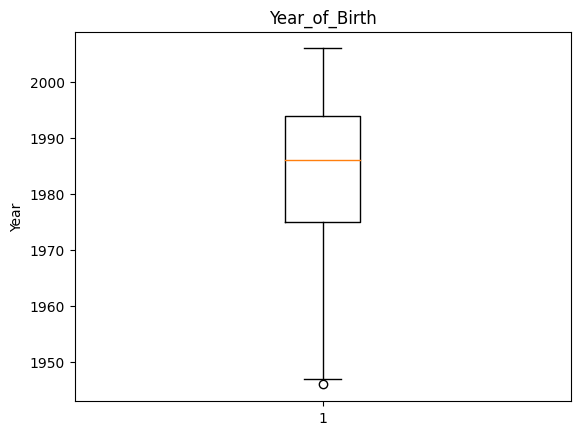

In [59]:
# Create a box plot using matplotlib
plt.boxplot(df["Year_of_Birth"])

# Set title and labels
plt.title('Year_of_Birth')
plt.ylabel('Year')

# Show the plot
plt.show()

- **Since there is presence of outlier, and the left (lower) whisker is longer than the right (upper) whisker, the distribution is left-skewed, meaning it has a tail on the left side (negative skewness). So, median is the best choice to impute Year_of_Birth using central tendancy measure.**

In [60]:
merged_df["Marital_Status"] = merged_df["Marital_Status"].fillna(merged_df["Marital_Status"].mode()[0])
merged_df["Year_of_Birth"] =merged_df["Year_of_Birth"].fillna(merged_df["Year_of_Birth"].median())

In [61]:
merged_df['Year_of_Birth'] = merged_df['Year_of_Birth'].round().astype(int) # Round the Year_of_Birth to nearest integer value.

## ***Imputing missing values for other attributes having null***



1.   Date_Resigned can be null
2.   I don't have further access about 'Hourly_Time', 'Late_minutes', 'Type_Full Day', 'Type_Half Day', 'apply_type_Anual', 'apply_type_Casual', 'Earnings', 'Total Fixed'.
3. There is a possibility to have that null values as zero. So, To fill them we need the information why they are missing. For example If we get information Employees whose records not in leaves.csv didn't take any leave.






***Hence,I skipped the imputation of null values for the above variables***

## ***Create new features***

> Create features Resigned_Age and Worked_Duration. Because, they may provide significance information about target variable Status



In [62]:
merged_df['Resigned_Age'] = merged_df['Date_Resigned'].dt.year - merged_df['Year_of_Birth']
merged_df['Worked_Duration'] = merged_df['Date_Resigned'].dt.year - merged_df['Year_Joined']

In [63]:
merged_df

,Employee_No,Title,Gender,Marital_Status,Date_Joined,Date_Resigned,Status,Employment_Category,Employment_Type,Religion,...,Late_minutes,Type_Full Day,Type_Half Day,apply_type_Anual,apply_type_Casual,Earnings,Total Fixed,Year_Joined,Resigned_Age,Worked_Duration
0,347,Mr,Male,Married,1993-12-08,NaT,Active,Staff,Permanant,Buddhist,...,19.107082,16.0,6.0,11.0,11.0,36717.818889,34500.0,1993,NaN,NaN
1,348,Mr,Male,Married,1995-03-14,NaT,Active,Staff,Permanant,Buddhist,...,96.275944,5.0,7.0,5.0,7.0,61777.027778,32300.0,1995,NaN,NaN
2,349,Mr,Male,Married,1988-01-27,2021-06-28,Inactive,Staff,Permanant,Buddhist,...,46.942271,NaN,NaN,NaN,NaN,NaN,NaN,1988,47.0,33.0
3,351,Ms,Female,Married,1999-10-01,2022-01-31,Inactive,Staff,Permanant,Catholic,...,14.105595,4.0,6.0,0.0,10.0,50981.560000,49600.0,1999,48.0,23.0
4,352,Mr,Male,Married,2001-01-26,NaT,Active,Staff,Permanant,Buddhist,...,39.973482,NaN,NaN,NaN,NaN,37325.784118,27350.0,2001,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,2836,Ms,Female,Single,2022-11-01,2022-12-22,Inactive,Staff,Contarct Basis,Buddhist,...,5.849561,NaN,NaN,NaN,NaN,50000.000000,50000.0,2022,29.0,0.0
993,2890,Mr,Male,Single,2022-11-21,NaT,Active,Staff,Contarct Basis,Buddhist,...,64.324797,NaN,NaN,NaN,NaN,70000.000000,70000.0,2022,NaN,NaN
994,2972,Mr,Male,Single,2022-12-05,NaT,Active,Staff,Contarct Basis,Buddhist,...,23.227778,1.0,2.0,0.0,3.0,60000.000000,60000.0,2022,NaN,NaN
995,2973,Mr,Male,Single,2022-12-08,NaT,Active,Staff,Contarct Basis,Buddhist,...,12.434848,NaN,NaN,NaN,NaN,80000.000000,80000.0,2022,NaN,NaN


In [64]:
merged_df.to_csv('employee_preprocess_200635E.csv', index=False)